<a href="https://colab.research.google.com/github/Priyankavaishnav1006/Stock_Sales_ML_Model/blob/main/Stock_sales_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import pandas as pd

file_path= '/content/drive/MyDrive/ML Data 2.csv'
df = pd.read_csv(file_path)

#check 1st five and last five rows
print(df)

#check columns and data type
print(df.info())

          Rows No  Location ID    DealDate Currency Type  Type  Amount  \
0        28937647          140  04/01/2022      JMD    N     S   77000   
1        28937648          140  04/01/2022      XCD    N     S    1000   
2        28937649          140  04/01/2022      KRW    N     S  910000   
3        28937650          140  04/01/2022      EUR    N     S     705   
4        28937651          140  04/01/2022      TRY    N     S    3215   
...           ...          ...         ...      ...  ...   ...     ...   
8234155  46696722           38  30/04/2025      EUR    N     S     335   
8234156  46696723           38  30/04/2025      EUR    N     B     200   
8234157  46696724           38  30/04/2025      EUR    N     S     100   
8234158  46696725           38  30/04/2025      JPY    N     S   27000   
8234159  46696726          272  29/04/2025      EUR    N     S     340   

          Value  OriginationID  OrderTypeID  
0        401.68              2            2  
1        293.17    

# New section

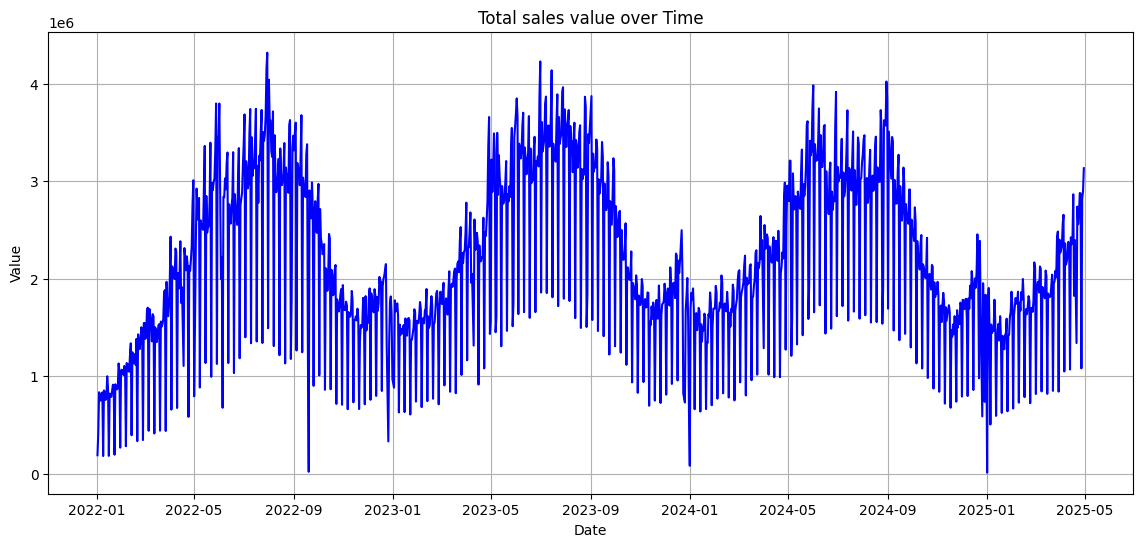

In [2]:
import warnings
warnings.filterwarnings("ignore")   # Ignore warnings

# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import holidays
from xgboost import XGBRegressor

# Load the data into a pandas DataFrame
file_path= '/content/drive/MyDrive/ML Data 2.csv'
df = pd.read_csv(file_path)

#convert 'Deal date' to dataframe
df['DealDate'] = pd.to_datetime(df['DealDate'],dayfirst=True)


#Data Visualization total sales value over time.
daily_sales = df.groupby('DealDate')['Value'].sum().reset_index() # Corrected column name

plt.figure(figsize=(14,6))
plt.plot(daily_sales['DealDate'],daily_sales['Value'],color='blue') # Corrected column name
plt.title('Total sales value over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()
# Plot Sales Trend Over Time (All Currencies Combined)

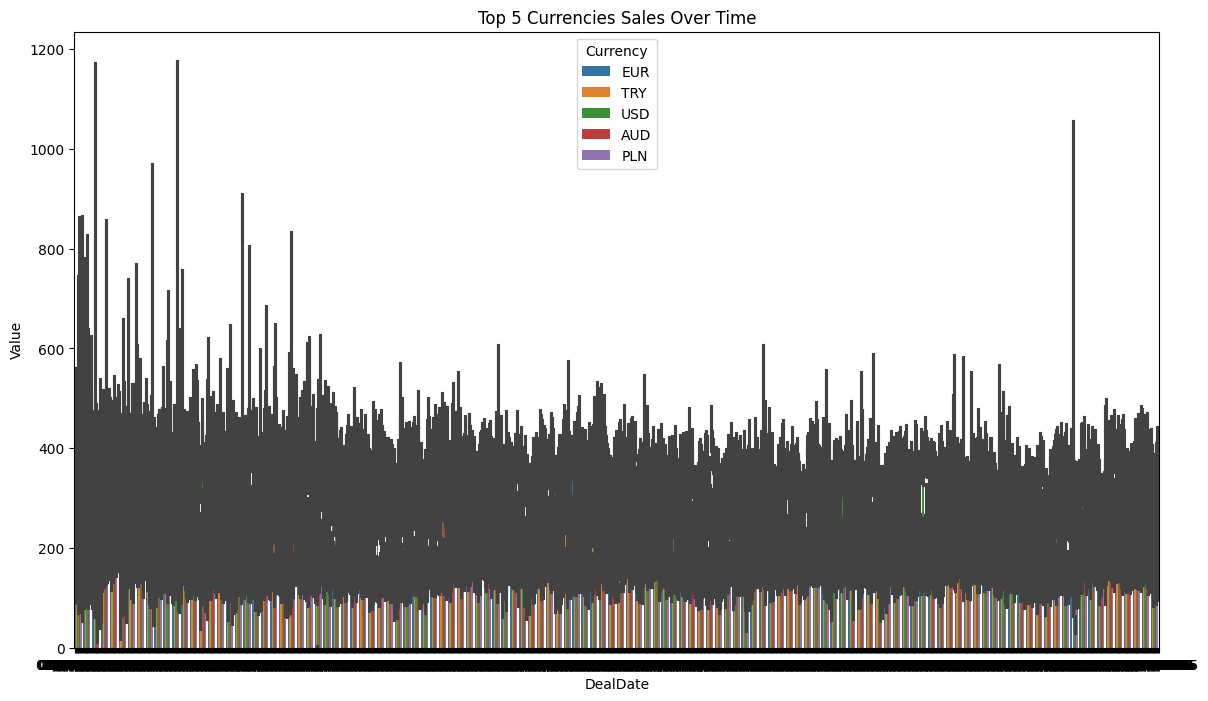

In [10]:
#Sales Trend per Currency (Example: Top 5)
top_currencies = df['Currency'].value_counts().head(5).index
df_top = df[df['Currency'].isin(top_currencies)]

plt.figure(figsize=(14, 8))
sns.barplot(data=df_top, x='DealDate', y='Value', hue='Currency')
plt.title('Top 5 Currencies Sales Over Time')
plt.show()

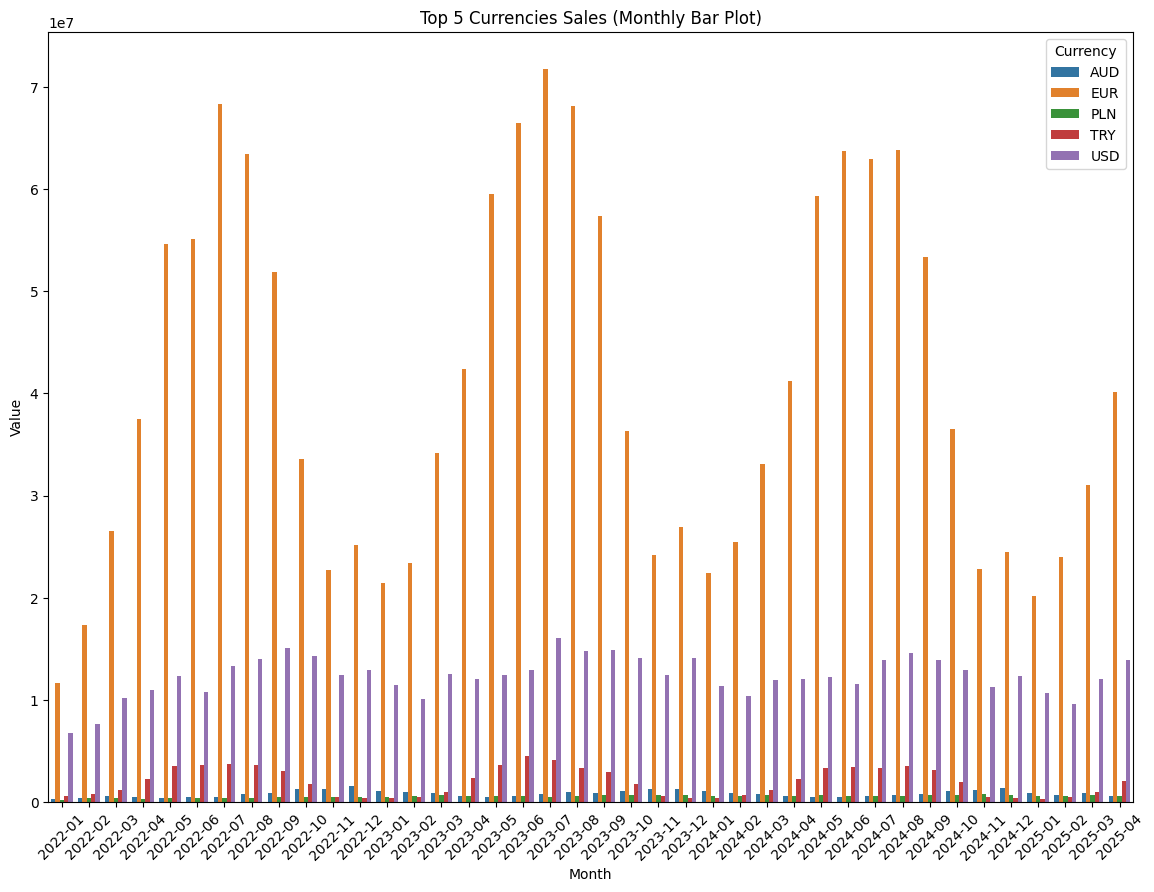

In [14]:
# Create 'Month' column
df_top['Month'] = df_top['DealDate'].dt.to_period('M').astype(str)

# Group by Month and Currency
df_monthly = df_top.groupby(['Month', 'Currency']).agg({'Value': 'sum'}).reset_index()

# Bar plot
plt.figure(figsize=(14, 10))
sns.barplot(data=df_monthly, x='Month', y='Value', hue='Currency')
plt.title('Top 5 Currencies Sales (Monthly Bar Plot)')
plt.xticks(rotation=45)
plt.show()


In [13]:
# Sales Trend per Branch as Data (Not Plot)

# Group by Branch and Currency
df_branch = df.groupby(['Location ID', 'Currency']).agg({'Value': 'sum'}).reset_index()

# Show top rows
print("\nCurrency Sales Value by Branch (Location ID):")
print(df_branch.sort_values(by='Value', ascending=False).head(20))  # Top 20 rows


Currency Sales Value by Branch (Location ID):
       Location ID Currency         Value
8224           140      EUR  1.060422e+08
3676            65      EUR  3.044190e+07
8270           140      USD  2.985635e+07
8226           140      GBP  2.025591e+07
6566           113      EUR  1.925533e+07
4214            75      EUR  1.740912e+07
1341            28      EUR  1.735028e+07
4744            84      EUR  1.689981e+07
7895           134      EUR  1.594578e+07
7766           132      EUR  1.579105e+07
3270            59      EUR  1.575858e+07
4144            73      EUR  1.522902e+07
6769           116      EUR  1.412772e+07
4416            79      EUR  1.389575e+07
10236          172      EUR  1.371155e+07
3202            58      EUR  1.323881e+07
3808            67      EUR  1.283205e+07
11081          186      EUR  1.282042e+07
9494           160      EUR  1.280423e+07
6157           107      EUR  1.266428e+07


In [15]:
branch_sales = df.groupby('Location ID')['Value'].sum().reset_index().sort_values(by='Value', ascending=False)
print(branch_sales)

     Location ID         Value
123          140  2.043397e+08
55            65  4.372696e+07
20            28  3.115195e+07
98           113  2.825174e+07
63            75  2.544149e+07
..           ...           ...
252          282  4.393004e+05
189          216  3.143203e+05
220          248  1.787840e+05
194          222  1.087436e+05
244          272  1.539304e+04

[253 rows x 2 columns]


In [17]:
#Monthly Sales per Branch
# Convert 'DealDate' to datetime if not done already
df['DealDate'] = pd.to_datetime(df['DealDate'], dayfirst=True)

# Create 'Month' column
df['Month'] = df['DealDate'].dt.to_period('M')

# Group by Month and Branch
monthly_branch_sales = df.groupby(['Month', 'Location ID'])['Value'].sum().reset_index()

# Show results
print(monthly_branch_sales)

        Month  Location ID      Value
0     2022-01            5   70615.84
1     2022-01            6   59745.49
2     2022-01            9   29661.98
3     2022-01           10  144107.98
4     2022-01           11  173849.63
...       ...          ...        ...
8638  2025-04          278   50096.99
8639  2025-04          279  134928.42
8640  2025-04          280  188247.96
8641  2025-04          281  269651.98
8642  2025-04          282   50661.91

[8643 rows x 3 columns]


In [18]:
# Create 'Week' column
df['Week'] = df['DealDate'].dt.to_period('W')

# Group by Week and Branch
weekly_branch_sales = df.groupby(['Week', 'Location ID'])['Value'].sum().reset_index()

# Show results
print(weekly_branch_sales)

                        Week  Location ID     Value
0      2021-12-27/2022-01-02           11   3319.73
1      2021-12-27/2022-01-02           15    676.18
2      2021-12-27/2022-01-02           28   9160.85
3      2021-12-27/2022-01-02           36   2940.39
4      2021-12-27/2022-01-02           44   1911.16
...                      ...          ...       ...
37347  2025-04-28/2025-05-04          278   3722.58
37348  2025-04-28/2025-05-04          279   9644.90
37349  2025-04-28/2025-05-04          280  22662.74
37350  2025-04-28/2025-05-04          281  32874.38
37351  2025-04-28/2025-05-04          282  10369.57

[37352 rows x 3 columns]


In [19]:
currency_sales = df.groupby('Currency')['Value'].sum().reset_index().sort_values(by='Value', ascending=False)
print(currency_sales)

   Currency         Value
24      EUR  1.624631e+09
74      USD  4.934190e+08
70      TRY  7.847823e+07
0       AED  3.685932e+07
1       AUD  3.313679e+07
..      ...           ...
29      GS1  3.183000e+03
52      NAD  2.627400e+03
46      LBP  1.976790e+03
32      HNL  3.075900e+02
73      UAH  1.174000e+01

[80 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptlutt5g_/qyaxiwe_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptlutt5g_/isiyd7hd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51283', 'data', 'file=/tmp/tmptlutt5g_/qyaxiwe_.json', 'init=/tmp/tmptlutt5g_/isiyd7hd.json', 'output', 'file=/tmp/tmptlutt5g_/prophet_modelj4igm6h4/prophet_model-20250618081331.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:13:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:13:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


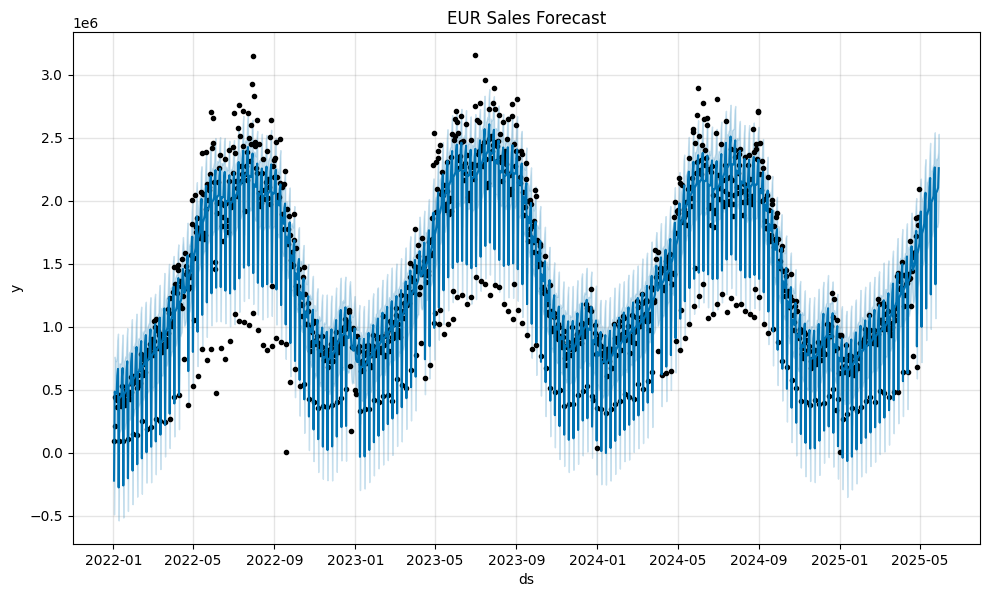

In [20]:
#Prophet Forecasting (EUR Example)

df_eur = df[df['Currency'] == 'EUR'][['DealDate', 'Value']]
df_eur = df_eur.groupby('DealDate').sum().reset_index()
df_eur.columns = ['ds', 'y']

model = Prophet()
model.fit(df_eur)

future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

fig1 = model.plot(forecast)
plt.title('EUR Sales Forecast')
plt.show()

In [30]:
# Prepare data for Prophet
prophet_df = daily_sales.rename(columns={'DealDate': 'ds', 'Value': 'y'})

In [28]:
# Calculate daily sales
daily_sales = df.groupby('DealDate')['Value'].sum().reset_index()

# Prepare data for Prophet
prophet_df = daily_sales.rename(columns={'DealDate': 'ds', 'Value': 'y'})
display(prophet_df.head())

,ds,y
0,2022-01-02,191460.75
1,2022-01-03,417154.59
2,2022-01-04,836672.99
3,2022-01-05,778501.24
4,2022-01-06,750613.25


In [31]:
# Prophet Model with holidays
m = Prophet()
m.add_country_holidays(country_name='GB')
m.fit(prophet_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptlutt5g_/ja7dwe36.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptlutt5g_/624g1nkx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96145', 'data', 'file=/tmp/tmptlutt5g_/ja7dwe36.json', 'init=/tmp/tmptlutt5g_/624g1nkx.json', 'output', 'file=/tmp/tmptlutt5g_/prophet_modell19ed4h7/prophet_model-20250618082854.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:28:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:28:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [33]:
# Forecasting next 30 days
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)

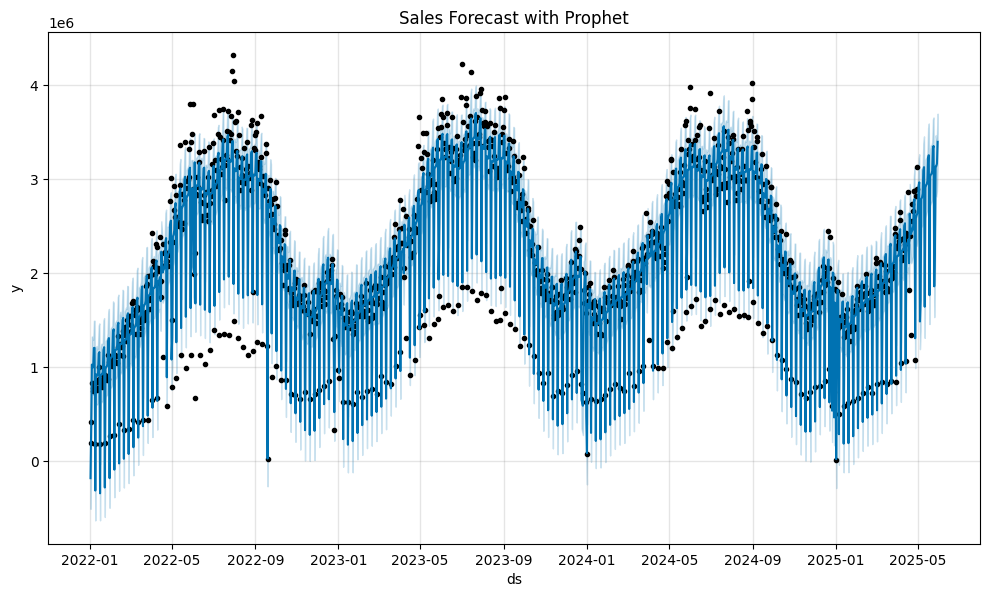

In [34]:
# Prophet Plot
m.plot(forecast)
plt.title('Sales Forecast with Prophet')
plt.show()

In [35]:
# Prepare features for ML models
df_ml = df.copy()
df_ml['Year'] = df_ml['DealDate'].dt.year
df_ml['Month'] = df_ml['DealDate'].dt.month
df_ml['Week'] = df_ml['DealDate'].dt.isocalendar().week
df_ml['Day'] = df_ml['DealDate'].dt.day
df_ml['DayofWeek'] = df_ml['DealDate'].dt.dayofweek
df_ml['IsHoliday'] = df_ml['DealDate'].isin(uk_holidays)

In [19]:
eur_df = df[df['Currency'] == 'EUR']
eur_df['DealDate'] = pd.to_datetime(eur_df['DealDate'], format='%d/%m/%Y') # Convert to datetime with correct format
eur_df_grouped = eur_df.groupby('DealDate').agg({'Value': 'sum'}).reset_index()
eur_df_grouped.rename(columns={'DealDate': 'ds', 'Value': 'y'}, inplace=True)
eur_df_grouped.head()

,ds,y
0,2022-01-02,95453.42
1,2022-01-03,211606.51
2,2022-01-04,442671.93
3,2022-01-05,423721.27
4,2022-01-06,364979.23


In [22]:
train_size = int(len(eur_df_grouped) * 0.7)
train_df = eur_df_grouped.iloc[:train_size].copy()
test_df = eur_df_grouped.iloc[train_size:].copy()

In [28]:
#Filter EUR sales only
df_eur = df[df['Currency'] == 'EUR'].copy()


#Prepare for Prophet (ds, y format)
df_prophet = df_eur[['DealDate', 'Value']].rename(columns={'DealDate': 'ds', 'Value': 'y'})
# 5️⃣ Train-test split (70-30)
train_size = int(len(df_prophet) * 0.7)
train_df = df_prophet.iloc[:train_size]
test_df = df_prophet.iloc[train_size:]

In [33]:
# Aggregate daily EUR sales (or you can do weekly/monthly if needed)
eur_daily = eur_df.groupby('DealDate')['Value'].sum().reset_index()

# Rename columns as Prophet expects: ds (date) and y (value)
eur_daily.rename(columns={'DealDate': 'ds', 'Value': 'y'}, inplace=True)



# Initialize Prophet model
m = Prophet()

# Fit model
m.fit(eur_daily)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoatvzrdu/bi3ic01i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoatvzrdu/1nzoq8b1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23893', 'data', 'file=/tmp/tmpoatvzrdu/bi3ic01i.json', 'init=/tmp/tmpoatvzrdu/1nzoq8b1.json', 'output', 'file=/tmp/tmpoatvzrdu/prophet_modelm6zs2mft/prophet_model-20250618092144.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:21:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:21:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


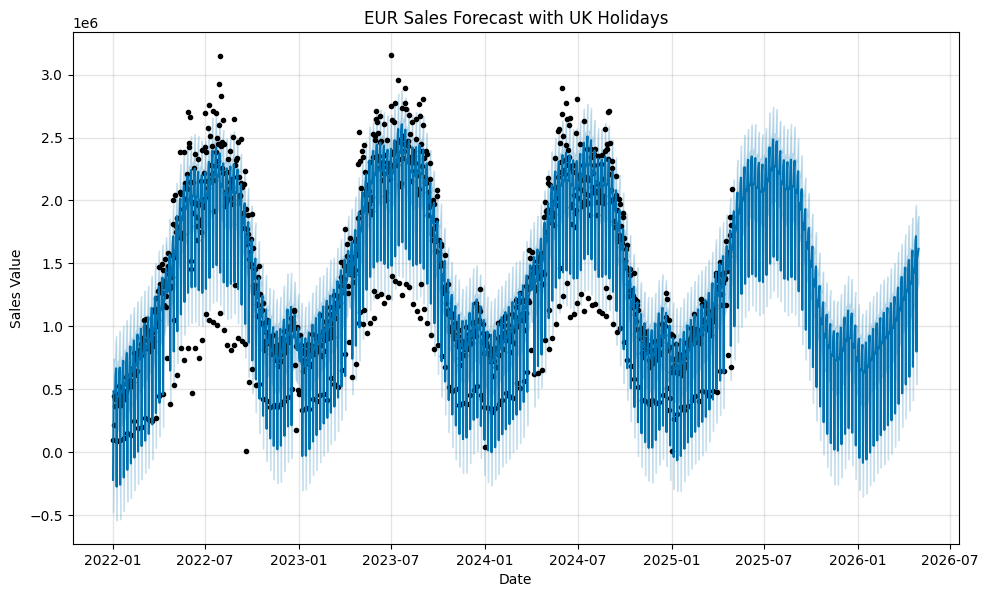

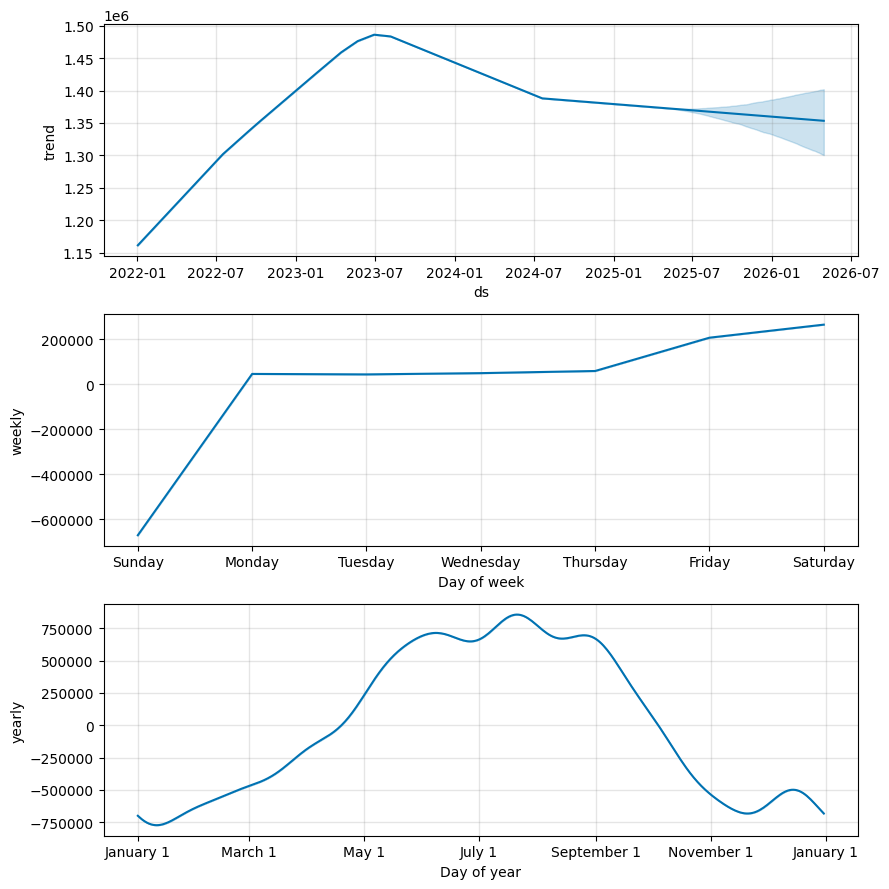

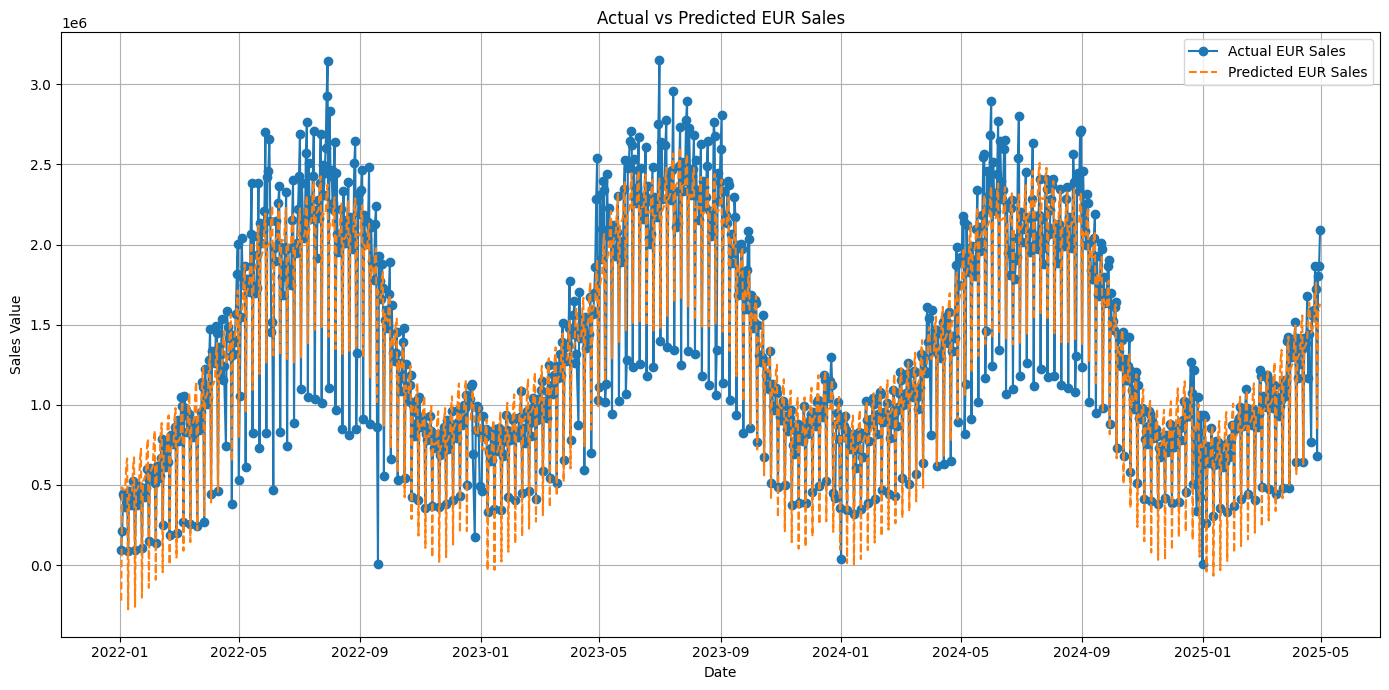

In [37]:
import matplotlib.pyplot as plt

# Create future dataframe for forecasting
future = m.make_future_dataframe(periods=365) # Forecast for the next year

# Make predictions
forecast = m.predict(future)

# Plot forecast
fig1 = m.plot(forecast)
plt.title('EUR Sales Forecast with UK Holidays')
plt.xlabel('Date')
plt.ylabel('Sales Value')
plt.show()

# Plot components
fig2 = m.plot_components(forecast)
plt.show()

# Merge actual and predicted values for historical dates
comparison = pd.merge(
    eur_daily,
    forecast[['ds', 'yhat']],
    on='ds',
    how='left')




# Plot Actual vs Predicted EUR sales over time
plt.figure(figsize=(14, 7))
plt.plot(comparison['ds'], comparison['y'], label='Actual EUR Sales', marker='o')
plt.plot(comparison['ds'], comparison['yhat'], label='Predicted EUR Sales', linestyle='--')
plt.title('Actual vs Predicted EUR Sales')
plt.xlabel('Date')
plt.ylabel('Sales Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()